# Fraud Detection Case Study

The objective is to build a machine learning model that predicts whether a transaction is fraudulent (isFraud = 1) or legitimate (isFraud = 0). The business goal is to reduce financial loss by detecting fraud early while minimizing false positives.

### Importing Libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


### Loading dataset

In [109]:
df = pd.read_csv("Fraud.csv")
row, col = df.shape
print("dataset contains ", row," rows and ", col, " coloumns")
df.head()

dataset contains  6362620  rows and  11  coloumns


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Understanding Dataset

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [111]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Preprocessing

1. Outlier Treatment

Transaction amount is highly skewed. Extremely large values can distort model learning.  
Instead of removing all outliers blindly, we capped the upper extreme at the 99.9th percentile to reduce noise while preserving fraud patterns.


In [112]:
df = df[df["amount"] < df["amount"].quantile(0.999)]

2. Missing Values

In [113]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

This Dataset contains no missing Values. If null/missing values was present can be handle by mean/median or other immputive methods.

3. Multicollinearity Check

Highly correlated variables can reduce model interpretability and stability.  
We used correlation analysis to detect multicollinearity.


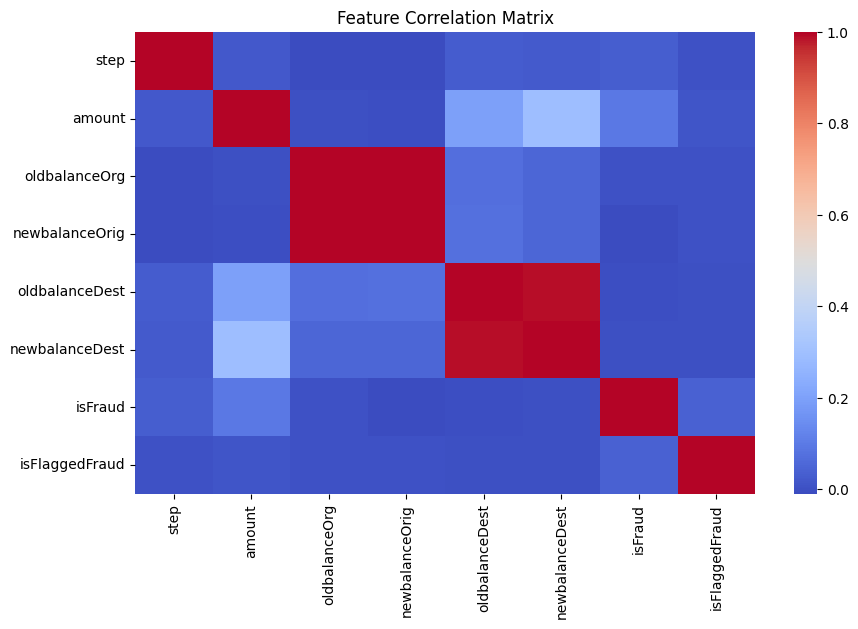

In [115]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

Strong correlation between:

oldbalanceOrg & newbalanceOrig

ldbalanceDest & newbalanceDest

tree-based models were preferred because they are robust to multicollinearity.

In [116]:
df['isFraud'].value_counts()

isFraud
0    6348394
1       7863
Name: count, dtype: int64

Fraud cases represent a very small percentage of the dataset.  
This creates a class imbalance problem where accuracy alone becomes misleading.

In [117]:
df["isFraud"].value_counts(normalize=True)

isFraud
0    0.998763
1    0.001237
Name: proportion, dtype: float64

Since fraud is rare, we will evaluate the model using:
- Precision  
- Recall  
- F1-score  
- ROC-AUC  

Recall is especially important because missing a fraud case is costly.

### Handling large dataset

The original dataset is very large (6.3M rows). To allow model development on a local machine while preserving data characteristics, stratified sampling was applied.

In [118]:
df_sampled = df.groupby('isFraud', group_keys=False).apply(
lambda x: x.sample(frac=0.2, random_state=42)
)


print(df_sampled.shape)
print(df_sampled['isFraud'].value_counts(normalize=True) * 100)

(1271252, 11)
isFraud
0    99.876264
1     0.123736
Name: proportion, dtype: float64


In [119]:
df = df_sampled.copy()

This preserves the fraud distribution while making computation feasible.

### Feature Engineering

##### One Hot Encoding 

Changing the categorical data to numerical i.e. "type" coloumn

In [120]:
df = pd.get_dummies(df, columns=["type"], drop_first=True)

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

print(X.shape)

df.head()


(1271252, 13)


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
5909857,404,21224.50,C1343599535,0.00,0.00,M135398447,0.00,0.00,0,0,False,False,True,False
7232,7,201011.68,C1351269492,2494724.15,2695735.83,C1674899618,6153407.58,10006403.16,0,0,False,False,False,False
3243822,250,3082664.13,C237964217,730.00,0.00,C1186800317,0.00,3082664.13,0,0,False,False,False,True
91050,10,140861.23,C218507256,2135792.42,2276653.65,C2035145536,3969175.52,3828314.29,0,0,False,False,False,False
702783,37,251782.58,C515557947,1425058.99,1676841.57,C1181594470,358129.91,106347.33,0,0,False,False,False,False



OldbalanceOrg & newbalanceOrig contain redundant information. Feature engineering helps reduce this issue by replacing them with balance change features.

In [121]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']


Droping the unneccesary coloumns

In [122]:
df = df.drop([
    'oldbalanceOrg', 
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'nameOrig',
    'nameDest'
], axis=1)

df.head()

,step,amount,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_change,dest_balance_change
5909857,404,21224.50,0,0,False,False,True,False,0.00,0.00
7232,7,201011.68,0,0,False,False,False,False,-201011.68,3852995.58
3243822,250,3082664.13,0,0,False,False,False,True,730.00,3082664.13
91050,10,140861.23,0,0,False,False,False,False,-140861.23,-140861.23
702783,37,251782.58,0,0,False,False,False,False,-251782.58,-251782.58


#### Separating the Features

In [123]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']


#### Train Test Split

Using Stratify as y due to high imbalance in result data.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1017001, 9) (1017001,) (254251, 9) (254251,)


### Models

Logistic Regression

In [125]:
lr = LogisticRegression(max_iter= 1000)

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:,1]

In [126]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))
print("\nClassification Report:\n", classification_report(y_test, lr_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, lr_prob))


Accuracy:  0.9992330413646358
Confusion Matrix:
 [[253915     21]
 [   174    141]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    253936
           1       0.87      0.45      0.59       315

    accuracy                           1.00    254251
   macro avg       0.93      0.72      0.80    254251
weighted avg       1.00      1.00      1.00    254251


ROC-AUC Score: 0.9922339137070408


Accuracy might be high due imbalance data. So, we will try to reduce type 2 error

In [130]:
lr_balanced = LogisticRegression( max_iter=1000, class_weight='balanced')

lr_balanced.fit(X_train, y_train)

bal_pred = lr_balanced.predict(X_test)
bal_prob = lr_balanced.predict_proba(X_test)[:, 1]



In [131]:

print("Confusion Matrix:\n", confusion_matrix(y_test, bal_pred))
print("\nClassification Report:\n", classification_report(y_test, bal_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, bal_prob))

Confusion Matrix:
 [[239748  14188]
 [     7    308]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    253936
           1       0.02      0.98      0.04       315

    accuracy                           0.94    254251
   macro avg       0.51      0.96      0.51    254251
weighted avg       1.00      0.94      0.97    254251


ROC-AUC Score: 0.9918156855920701


Random Forest

We use Random Forest Classifier because:
- It handles non-linear patterns  
- It performs well on imbalanced data  
- It is robust to multicollinearity  
- It provides feature importance  

In [132]:

rf = RandomForestClassifier(
    n_estimators=100,       
    max_depth=14,           
    min_samples_leaf=30,   
    class_weight={0:1, 1:5},
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]


In [133]:

print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, rf_prob))

Confusion Matrix:
 [[253915     21]
 [    89    226]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    253936
           1       0.91      0.72      0.80       315

    accuracy                           1.00    254251
   macro avg       0.96      0.86      0.90    254251
weighted avg       1.00      1.00      1.00    254251


ROC-AUC Score: 0.997044024591123


Threshold tuning was used to balance fraud recall and false positives, reflecting real-world business trade-offs.

In [134]:
rf_prob = rf.predict_proba(X_test)[:, 1]

for threshold in [0.5, 0.4, 0.3, 0.25, 0.2]:
    rf_pred_custom = (rf_prob >= threshold).astype(int)
    
    print(f"\nThreshold: {threshold}")
    print(confusion_matrix(y_test, rf_pred_custom))
    print(classification_report(y_test, rf_pred_custom))



Threshold: 0.5
[[253915     21]
 [    89    226]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253936
           1       0.91      0.72      0.80       315

    accuracy                           1.00    254251
   macro avg       0.96      0.86      0.90    254251
weighted avg       1.00      1.00      1.00    254251


Threshold: 0.4
[[253896     40]
 [    85    230]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253936
           1       0.85      0.73      0.79       315

    accuracy                           1.00    254251
   macro avg       0.93      0.87      0.89    254251
weighted avg       1.00      1.00      1.00    254251


Threshold: 0.3
[[253844     92]
 [    77    238]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253936
           1       0.72      0.76      0.74       315

    accuracy                 

A threshold of 0.3 provides the optimal balance between fraud detection and customer impact. At this threshold, the model captures approximately 76% of fraudulent transactions while maintaining reasonable precision, thereby minimizing financial loss without generating excessive false positives.

In [135]:
threshold = 0.3
rf_pred = (rf_prob >= threshold).astype(int)

#### Feature Importance (Key Fraud Predictors)


In [136]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


orig_balance_change    0.462892
dest_balance_change    0.339686
step                   0.069053
amount                 0.060477
type_TRANSFER          0.042706
type_CASH_OUT          0.022676
type_PAYMENT           0.002444
type_DEBIT             0.000066
isFlaggedFraud         0.000000
dtype: float64

#### Key Factors That Predict Fraud

The most important features include:
- Transaction amount  
- Transaction type (especially TRANSFER and CASH_OUT)  
- Sudden drop in origin account balance  
- Abnormal changes in destination balance  

These indicate suspicious behavior patterns.


#### Do These Factors Make Sense?

Yes, these factors logically align with real-world fraud behavior:

- Fraudsters often attempt large transfers  
- Sudden zero balance may indicate account takeover  
- TRANSFER and CASH_OUT are common channels used for fraud  
- Genuine users typically have smoother balance changes  

This means the model is learning meaningful patterns, not random noise.


### Measuring Effectiveness After Deployment

Once deployed, the system’s effectiveness should be measured using:

- Reduction in total fraud loss  
- Increase in fraud detection rate (recall)  
- Reduction in false negatives  
- Monitoring false positives to protect genuine users  
- Regular model retraining for concept drift  
- A/B testing between old system and ML-based system 

### Conclusion

Multiple models were evaluated for fraud detection. Random Forest, combined with threshold tuning, provided the best balance between catching fraudulent transactions and minimizing unnecessary customer disruption.

This project demonstrates a complete, interpretable, and business-aligned fraud detection pipeline suitable for real-world deployment.

In [137]:
import joblib

joblib.dump(rf, "rf_model.pkl")

print("Model saved as rf_model.pkl")


Model saved as rf_model.pkl


In [139]:

loaded_model = joblib.load("rf_model.pkl")

print("Model loaded successfully")


Model loaded successfully


In [227]:
# Take a random transaction every time
sample = X_test.sample(1)

print("Sample transaction:")
display(sample)

sample_prob = loaded_model.predict_proba(sample)[0][1]
sample_pred = 1 if sample_prob >= 0.3 else 0

print("\nFraud probability:", sample_prob)
print("Prediction (threshold 0.3):", "Fraud" if sample_pred == 1 else "Not Fraud")


Sample transaction:


,step,amount,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_change,dest_balance_change
505642,20,308346.37,0,False,False,False,False,-308346.37,119189.25



Fraud probability: 8.654729492802628e-05
Prediction (threshold 0.3): Not Fraud


Checking for fraud cases

In [232]:
fraud_sample = X_test[y_test == 1].sample(1)

display(fraud_sample)

prob = loaded_model.predict_proba(fraud_sample)[0][1]
pred = "Fraud" if prob >= 0.3 else "Not Fraud"

print("Fraud probability:", prob)
print("Prediction:", pred)


,step,amount,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_change,dest_balance_change
6264975,613,327791.14,0,False,False,False,True,327791.14,0.0


Fraud probability: 0.9403890636728737
Prediction: Fraud
